(494, 2)
(494, 2)


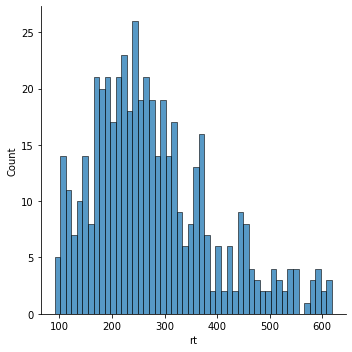

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.inchi import *
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
import logging
from multiprocessing import Pool
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils import *
from custom_layers import *
from model import *
from plots import *
from evals import *
#remove RDKit warnings
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

np.random.seed(456)
tf.random.set_seed(456)
import configparser
config = configparser.ConfigParser()
config.read('./config.cfg')
def getConfig(section, attribute, default=""):
    try:
        return config[section][attribute]
    except:
        return default
dataset_file = getConfig("Task","dataset")

dataset_name = dataset_file.split("/")[len(dataset_file.split("/"))-1].rstrip('.csv')

rt_threshold = float(getConfig("Task", "rt_min"))
figures_path=getConfig("Task", "figures_path")
model_path = getConfig("Task", "model_path")
results_path = getConfig("Task", "results_path")




pretrained_path = getConfig("Task", "pretrained_path")
transfer_learning = getConfig("Task", "transfer learning")
cv= getConfig("Task", "CV")
if cv=="True":
    n_folds=5
else:
    n_folds=2


#read dataset as dataframe
df = pd.read_csv(dataset_file,sep=';')[['inchi', 'rt']]
print(df.shape)
sns.displot(df.rt, bins=50)
plt.savefig((figures_path+'/'+dataset_name+'_distribution'+'.svg'))
#remove non-retained molecules
df = df[df.rt>=rt_threshold]
print(df.shape)
#generate smiles instead of inchies
df['smiles'] = df.inchi.apply(inchi2smiles)
df=df[df.smiles!='NA']

x=graphs_from_smiles(df.smiles)
y = df.rt.values
#get an independent test set (one for all CV splits)


permuted_indices = np.random.permutation(np.arange(df.shape[0]))
train_index = permuted_indices[: int(df.shape[0] * 0.80)]
test_index = permuted_indices[int(df.shape[0] * 0.80) :]

X = [x[i][train_index]for i in range(len(x))]
x_test = [x[i][test_index] for i in range(len(x))]
Y = y[train_index]
y_test = y[test_index]
mpnn = MPNNModel_frozen(atom_dim=X[0][0][0].shape[0], bond_dim=X[1][0][0].shape[0], batch_size=8)
lr=0.0002
mpnn.compile(loss=keras.losses.MeanAbsoluteError(),optimizer=keras.optimizers.Adam(learning_rate=lr),
             metrics=[keras.metrics.MeanAbsoluteError(name="MAE")],            
            )
            
            
keras.utils.plot_model(mpnn, to_file='model.png',show_dtype=True, show_shapes=True, dpi=1200)           

In [2]:
!pip install pydot